## **AI Agent System Project**
We'll build a system with four specialized AI agents:

1. **Research Agent** 🔍
   - Uses TavilySearch to find current, accurate information
   - Gathers relevant facts, examples, and real-world applications
   - Ensures content is up-to-date and factually grounded
   - **Autonomy**: Decides what to search for based on the topic

2. **Math Item Generator Agent** 📐
   - Specializes in creating mathematical assessment items
   - Focuses on 8th-grade algebra, geometry, and problem-solving
   - Uses research context to create relevant, engaging problems
   - **Autonomy**: Determines appropriate difficulty and format

3. **Science Item Generator Agent** 🔬
   - Specializes in creating science assessment items
   - Focuses on 8th-grade physics, chemistry, biology, earth science
   - Incorporates real-world phenomena and current scientific topics
   - **Autonomy**: Chooses appropriate examples and contexts

4. **Quality Reviewer Agent** ✅
   - Reviews generated items for accuracy and appropriateness
   - Checks difficulty level, clarity, and pedagogical soundness
   - Suggests improvements and validates final output
   - **Autonomy**: Decides whether to approve or request revisions

In [2]:
import os
from dotenv import load_dotenv
from typing import TypedDict, Annotated
from langchain_groq import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph, START, END
import operator

In [4]:
# ## 4. Set Up Agent Tools
# **Tools** are external capabilities that agents use. We'll use **TavilySearch** for web research.
# Initialize Tavily Search tool
search_tool = TavilySearchResults(
    max_results=3,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=False
)

# Test the search tool
print("🔍 Testing Tavily search...")
try:
    test_results = search_tool.invoke("8th grade algebra concepts")
    print(f"✅ Search working! Found {len(test_results)} results")
    print(f"Sample result: {test_results[0]['content'][:150]}...")
except Exception as e:
    print(f"❌ Search test failed: {e}")


🔍 Testing Tavily search...
✅ Search working! Found 3 results
Sample result: Explore and model exponential functions using graphs, tables and equations and by applying the rules for operations with exponents.
Construct, compare...


In [18]:
# 2. Initialize Language Model

# Initialize LLM for all agents
llm = ChatGroq(
    model="openai/gpt-oss-120b",
    temperature=0.7,
    max_tokens=1000
)

print("✅ Language model initialized")
print(f"   Model: openai/gpt-oss-120b")
print(f"   Temperature: 0.7")

✅ Language model initialized
   Model: openai/gpt-oss-120b
   Temperature: 0.7


In [5]:
# The **state** is a shared workspace where all agents read inputs and write outputs.

# %%
class AgentState(TypedDict):
    """State shared across all agents in the workflow"""
    
    # Input from user
    subject: str  # "math" or "science"
    topic: str    # Specific topic
    
    # Research agent outputs
    research_query: str
    research_results: str
    
    # Generator agent outputs
    generated_item: str
    
    # Reviewer agent outputs
    review_feedback: str
    final_item: str
    quality_score: int  # 1-10
    
    # Workflow tracking
    current_agent: str
    messages: Annotated[list, operator.add]  # Agent activity log

print("✅ Agent state structure defined")

✅ Agent state structure defined


In [5]:
def research_agent(state: AgentState) -> AgentState:
    """
    Research Agent: Gathers current information using web search.
    Uses tools autonomously to find relevant information.
    """
    print("\n🔍 Research Agent activated...")
    
    subject = state["subject"]
    topic = state["topic"]
    
    # Agent autonomously formulates search query
    search_query = f"8th grade {subject} {topic} real world examples applications"
    print(f"   Agent decision: Searching for '{search_query}'")
    
    # Agent uses tool to gather information
    search_results = search_tool.invoke(search_query)
    
    # Agent synthesizes findings using reasoning
    synthesis_prompt = f"""Based on these search results about {topic} in {subject}, 
    create a concise summary (3-4 sentences) highlighting:
    1. Key concepts suitable for 8th grade
    2. Real-world applications or examples
    3. Current relevance or interesting facts
    
    Search Results:
    {search_results}
    
    Provide only the summary, no preamble."""
    
    synthesis = llm.invoke(synthesis_prompt).content
    
    print(f"   ✅ Research complete! Agent synthesized {len(search_results)} sources")
    
    # Update state for next agents
    state["research_query"] = search_query
    state["research_results"] = synthesis
    state["current_agent"] = "research"
    state["messages"].append(f"Research Agent: Completed research on {topic}")
    
    return state

In [6]:
def math_generator_agent(state: AgentState) -> AgentState:
    """
    Math Item Generator Agent: Specializes in mathematical assessment creation.
    
    Agent Capabilities:
    - Understands mathematical concepts and pedagogy
    - Creates age-appropriate problems
    - Designs plausible distractors
    - Incorporates real-world context
    """
    print("\n📐 Math Generator Agent activated...")
    
    topic = state["topic"]
    research = state["research_results"]
    
    generation_prompt = f"""You are an expert 8th-grade mathematics assessment writer.
    
    Topic: {topic}
    Research Context: {research}
    
    Create ONE multiple-choice question that:
    
    1. CONTENT:
       - Tests understanding of {topic}
       - Uses concepts from the research context
       - Includes real-world application when possible
       - Appropriate for 8th-grade skill level
    
    2. DIFFICULTY:
       - Requires 2-3 steps to solve
       - Uses simple integers (avoid complex fractions)
       - Clear, unambiguous problem statement
    
    3. FORMAT:
       - Clear question stem
       - Exactly 4 options (A, B, C, D)
       - One correct answer
       - Three plausible distractors based on common errors
    
    4. EXPLANATION:
       - Step-by-step solution
       - Explains why correct answer is right
       - Addresses common misconceptions
    
    Use this EXACT format:
    
    Question: [Problem statement]
    
    A) [Option]
    B) [Option]
    C) [Option]
    D) [Option]
    
    Correct Answer: [Letter]
    
    Explanation:
    [Step-by-step solution]
    """
    
    generated_item = llm.invoke(generation_prompt).content
    
    print("   ✅ Agent generated math assessment item")
    
    # Update state
    state["generated_item"] = generated_item
    state["current_agent"] = "math_generator"
    state["messages"].append(f"Math Generator Agent: Created item on {topic}")
    
    return state

In [7]:
def science_generator_agent(state: AgentState) -> AgentState:
    """
    Science Item Generator Agent: Specializes in science assessment creation.
    
    Agent Capabilities:
    - Understands scientific concepts and inquiry
    - Creates phenomenon-based questions
    - Designs conceptual distractors
    - Incorporates current scientific topics
    """
    print("\n🔬 Science Generator Agent activated...")
    
    topic = state["topic"]
    research = state["research_results"]
    
    generation_prompt = f"""You are an expert 8th-grade science assessment writer.
    
    Topic: {topic}
    Research Context: {research}
    
    Create ONE multiple-choice question that:
    
    1. CONTENT:
       - Tests understanding of {topic}
       - Connects to real-world phenomena from research
       - Emphasizes scientific reasoning, not just facts
       - Appropriate for 8th-grade knowledge level
    
    2. COGNITIVE LEVEL:
       - Requires application or analysis (not just recall)
       - May include data interpretation or prediction
       - Tests conceptual understanding
    
    3. FORMAT:
       - Clear scenario or problem statement
       - Exactly 4 options (A, B, C, D)
       - One correct answer
       - Three plausible distractors based on misconceptions
    
    4. EXPLANATION:
       - Scientific reasoning for correct answer
       - Explains the underlying concept
       - Addresses common misconceptions
    
    Use this EXACT format:
    
    Question: [Scenario and question]
    
    A) [Option]
    B) [Option]
    C) [Option]
    D) [Option]
    
    Correct Answer: [Letter]
    
    Explanation:
    [Scientific reasoning]
    """
    
    generated_item = llm.invoke(generation_prompt).content
    
    print("   ✅ Agent generated science assessment item")
    
    # Update state
    state["generated_item"] = generated_item
    state["current_agent"] = "science_generator"
    state["messages"].append(f"Science Generator Agent: Created item on {topic}")
    
    return state

In [9]:
def quality_reviewer_agent(state: AgentState) -> AgentState:
    """
    Quality Reviewer Agent: Autonomous quality assurance specialist.
    
    Agent Capabilities:
    - Evaluates item quality across multiple dimensions
    - Identifies strengths and weaknesses
    - Makes approval/revision decisions
    - Improves items when necessary
    """
    print("\n✅ Quality Reviewer Agent activated...")
    
    generated_item = state["generated_item"]
    topic = state["topic"]
    subject = state["subject"]
    
    review_prompt = f"""You are an expert educational assessment reviewer.
    
    Subject: {subject}
    Topic: {topic}
    
    Review this assessment item:
    {generated_item}
    
    Evaluate on these criteria (1-10 scale):
    
    1. ACCURACY: Is all content factually correct?
    2. CLARITY: Is the question clear and unambiguous?
    3. DIFFICULTY: Appropriate for 8th grade level?
    4. DISTRACTORS: Are wrong answers plausible but clearly incorrect?
    5. PEDAGOGY: Does it test conceptual understanding?
    
    Provide:
    1. Overall quality score (1-10)
    2. Specific strengths (2-3 points)
    3. Areas for improvement (if any)
    4. Revised version (if score < 8)
    
    Format:
    QUALITY SCORE: [number]/10
    
    STRENGTHS:
    - [strength 1]
    - [strength 2]
    
    IMPROVEMENTS NEEDED:
    - [improvement 1] (if any)
    
    FINAL VERSION:
    [Revised item or "Approved as is"]
    """
    
    review = llm.invoke(review_prompt).content
    
    # Agent autonomously extracts quality score
    try:
        score_line = [line for line in review.split('\n') if 'QUALITY SCORE' in line][0]
        quality_score = int(score_line.split('/')[0].split(':')[1].strip())
    except:
        quality_score = 7
    
    print(f"   Agent evaluation: Quality Score = {quality_score}/10")
    
    # Agent makes approval decision
    if "Approved as is" in review or quality_score >= 8:
        final_item = generated_item
        print("   ✅ Agent decision: APPROVED")
    else:
        if "FINAL VERSION:" in review:
            final_item = review.split("FINAL VERSION:")[1].strip()
            print("   🔧 Agent decision: REVISED for improvement")
        else:
            final_item = generated_item
            print("   ⚠️  Agent decision: APPROVED with reservations")
    
    # Update state
    state["review_feedback"] = review
    state["final_item"] = final_item
    state["quality_score"] = quality_score
    state["current_agent"] = "reviewer"
    state["messages"].append(f"Quality Reviewer Agent: Scored {quality_score}/10")
    
    return state


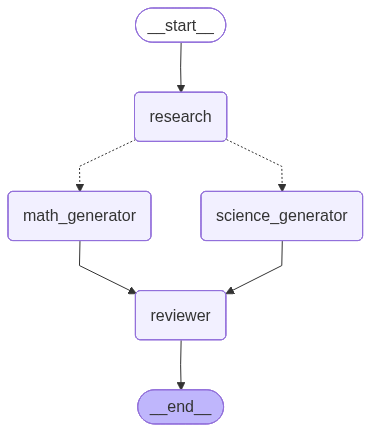

In [13]:
# 6. Build the AI Agent Workflow
from IPython.display import Image, display
# LangGraph allows us to orchestrate our AI agents in a coordinated workflow with **conditional routing** based on agent decisions.

# %%
def route_to_generator(state: AgentState) -> str:
    """
    Routing function: Agent workflow makes intelligent routing decisions.
    This demonstrates conditional agent behavior based on context.
    """
    subject = state["subject"].lower()
    
    if "math" in subject:
        return "math_generator"
    elif "science" in subject:
        return "science_generator"
    else:
        return "math_generator"

# Build the agent workflow graph
workflow = StateGraph(AgentState)

# Add agent nodes to the workflow
workflow.add_node("research", research_agent)
workflow.add_node("math_generator", math_generator_agent)
workflow.add_node("science_generator", science_generator_agent)
workflow.add_node("reviewer", quality_reviewer_agent)

# Define workflow edges (agent collaboration pathways)
workflow.set_entry_point("research")

# Conditional routing: workflow decides which generator to use
workflow.add_conditional_edges(
    "research",
    route_to_generator,
    {
        "math_generator": "math_generator",
        "science_generator": "science_generator"
    }
)

# Both generators route to quality reviewer
workflow.add_edge("math_generator", "reviewer")
workflow.add_edge("science_generator", "reviewer")
workflow.add_edge("reviewer", END)

# Compile the agent workflow
app = workflow.compile()

# Show the workflow
display(Image(app.get_graph().draw_mermaid_png()))

In [14]:
def generate_assessment_item(subject: str, topic: str):
    """
    Execute the AI agent system to generate an assessment item.
    
    This function initializes the agent state and runs the workflow,
    demonstrating how multiple AI agents collaborate to complete a complex task.
    """
    print(f"\n{'='*70}")
    print(f"🎯 AI AGENT SYSTEM: Generating {subject.upper()} item")
    print(f"📚 Topic: {topic}")
    print(f"{'='*70}")
    
    # Initialize agent state
    initial_state = {
        "subject": subject,
        "topic": topic,
        "research_query": "",
        "research_results": "",
        "generated_item": "",
        "review_feedback": "",
        "final_item": "",
        "quality_score": 0,
        "current_agent": "start",
        "messages": []
    }
    
    # Run the agent workflow
    final_state = app.invoke(initial_state)
    return final_state

In [20]:
# Run AI agent system for math
math_result = generate_assessment_item(
    subject="math",
    topic="solving linear equations with real-world applications"
)

print("\n" + "="*70)
print("📋 FINAL ITEM (Generated by AI Agents)")
print("="*70)
print(math_result["final_item"])

print("\n" + "="*70)
print("📊 AGENT SYSTEM METRICS")
print("="*70)
print(f"Quality Score: {math_result['quality_score']}/10")
print(f"\nAgent Activity Log:")
for msg in math_result["messages"]:
    print(f"  → {msg}")

print("\n" + "="*70)
print("🔍 RESEARCH AGENT FINDINGS")
print("="*70)
print(math_result["research_results"])


🎯 AI AGENT SYSTEM: Generating MATH item
📚 Topic: solving linear equations with real-world applications

🔍 Research Agent activated...
   Agent decision: Searching for '8th grade math solving linear equations with real-world applications real world examples applications'
   ✅ Research complete! Agent synthesized 3 sources

📐 Math Generator Agent activated...
   ✅ Agent generated math assessment item

✅ Quality Reviewer Agent activated...
   Agent evaluation: Quality Score = 7/10
   ✅ Agent decision: APPROVED

📋 FINAL ITEM (Generated by AI Agents)
**Question:** A family wants to buy a new TV that costs **$560**. They can set aside **$40** each week from their budget, and they already have **$80** saved. How many weeks will it take them to have enough money to purchase the TV?

A) 10 weeks  
B) 12 weeks  
C) 14 weeks  
D) 16 weeks  

**Correct Answer:** B  

**Explanation:**  

1. **Define the variable** – Let \(w\) = number of weeks needed.  

2. **Write the linear equation** – Money sa

In [21]:
# Run AI agent system for science
science_result = generate_assessment_item(
    subject="science",
    topic="photosynthesis and cellular respiration"
)

print("\n" + "="*70)
print("📋 FINAL ITEM (Generated by AI Agents)")
print("="*70)
print(science_result["final_item"])

print("\n" + "="*70)
print("📊 AGENT SYSTEM METRICS")
print("="*70)
print(f"Quality Score: {science_result['quality_score']}/10")
print(f"\nAgent Activity Log:")
for msg in science_result["messages"]:
    print(f"  → {msg}")

print("\n" + "="*70)
print("🔍 RESEARCH AGENT FINDINGS")
print("="*70)
print(science_result["research_results"])


🎯 AI AGENT SYSTEM: Generating SCIENCE item
📚 Topic: photosynthesis and cellular respiration

🔍 Research Agent activated...
   Agent decision: Searching for '8th grade science photosynthesis and cellular respiration real world examples applications'
   ✅ Research complete! Agent synthesized 3 sources

🔬 Science Generator Agent activated...
   ✅ Agent generated science assessment item

✅ Quality Reviewer Agent activated...
   Agent evaluation: Quality Score = 7/10
   ✅ Agent decision: APPROVED

📋 FINAL ITEM (Generated by AI Agents)
**Question:**  
A farmer is testing two temperature settings in a greenhouse to see how they affect wheat growth. He measures the net amount of carbon dioxide (CO₂) taken up by the plants each hour (net CO₂ uptake = CO₂ fixed by photosynthesis – CO₂ released by respiration).

| Temperature | Net CO₂ uptake (mg CO₂ · h⁻¹) |
|-------------|------------------------------|
| 20 °C       | +5                           |
| 30 °C       | +2                          

In [22]:
# To generate batch items, loop over topics

def batch_generate_items(item_specifications):
    """
    Use AI agents to generate multiple assessment items in batch.
    Demonstrates agent efficiency and consistency across multiple tasks.
    """
    results = []
    
    for i, (subject, topic) in enumerate(item_specifications, 1):
        print(f"\n🤖 AI Agents working on item {i}/{len(item_specifications)}...")
        
        try:
            result = generate_assessment_item(subject, topic)
            results.append({
                "subject": subject,
                "topic": topic,
                "item": result["final_item"],
                "quality_score": result["quality_score"],
                "research_used": result["research_results"]
            })
            print(f"   ✅ Agents completed item {i} (Score: {result['quality_score']}/10)")
        except Exception as e:
            print(f"   ❌ Agents failed on item {i}: {e}")
            results.append({
                "subject": subject,
                "topic": topic,
                "item": None,
                "quality_score": 0,
                "error": str(e)
            })
    
    return results

# Define items for agent system to generate
item_specs = [
    ("math", "systems of linear equations"),
    ("science", "Newton's laws of motion"),
    ("math", "geometric transformations"),
    ("science", "the water cycle and climate")
]

print("\n" + "="*70)
print("🚀 AI AGENT BATCH GENERATION: 4 ITEMS")
print("="*70)

batch_results = batch_generate_items(item_specs)

# Summary
print("\n" + "="*70)
print("📊 AI AGENT PERFORMANCE SUMMARY")
print("="*70)
for i, result in enumerate(batch_results, 1):
    status = "✅" if result["item"] else "❌"
    score = result.get("quality_score", 0)
    print(f"{status} Item {i}: {result['subject'].title()} - {result['topic']}")
    print(f"   Agent Quality Score: {score}/10")

avg_score = sum(r.get("quality_score", 0) for r in batch_results) / len(batch_results)
print(f"\n📈 Average Agent Performance: {avg_score:.1f}/10")



🚀 AI AGENT BATCH GENERATION: 4 ITEMS

🤖 AI Agents working on item 1/4...

🎯 AI AGENT SYSTEM: Generating MATH item
📚 Topic: systems of linear equations

🔍 Research Agent activated...
   Agent decision: Searching for '8th grade math systems of linear equations real world examples applications'
   ✅ Research complete! Agent synthesized 3 sources

📐 Math Generator Agent activated...
   ✅ Agent generated math assessment item

✅ Quality Reviewer Agent activated...
   Agent evaluation: Quality Score = 7/10
   ✅ Agent decision: APPROVED
   ✅ Agents completed item 1 (Score: 7/10)

🤖 AI Agents working on item 2/4...

🎯 AI AGENT SYSTEM: Generating SCIENCE item
📚 Topic: Newton's laws of motion

🔍 Research Agent activated...
   Agent decision: Searching for '8th grade science Newton's laws of motion real world examples applications'
   ✅ Research complete! Agent synthesized 3 sources

🔬 Science Generator Agent activated...
   ✅ Agent generated science assessment item

✅ Quality Reviewer Agent acti

In [23]:
# Comprehensive evaluation of agent system performance

def evaluate_agent_system(results_list):
    """
    Comprehensive evaluation of AI agent system performance.
    Analyzes how well the agents accomplished their goals.
    """
    print("\n" + "="*70)
    print("📊 AI AGENT SYSTEM EVALUATION")
    print("="*70)
    
    total_items = len(results_list)
    successful_items = sum(1 for r in results_list if r.get("item"))
    
    print(f"\n✅ Agent Success Rate: {successful_items}/{total_items} ({100*successful_items/total_items:.1f}%)")
    
    # Quality analysis
    scores = [r.get("quality_score", 0) for r in results_list if r.get("item")]
    if scores:
        avg_score = sum(scores) / len(scores)
        min_score = min(scores)
        max_score = max(scores)
        
        print(f"\n📈 Agent Quality Metrics:")
        print(f"   Average Score: {avg_score:.1f}/10")
        print(f"   Range: {min_score}-{max_score}")
        
        # Quality distribution
        excellent = sum(1 for s in scores if s >= 9)
        good = sum(1 for s in scores if 7 <= s < 9)
        acceptable = sum(1 for s in scores if 5 <= s < 7)
        poor = sum(1 for s in scores if s < 5)
        
        print(f"\n📊 Agent Output Quality Distribution:")
        print(f"   Excellent (9-10): {excellent} ({100*excellent/len(scores):.1f}%)")
        print(f"   Good (7-8):       {good} ({100*good/len(scores):.1f}%)")
        print(f"   Acceptable (5-6): {acceptable} ({100*acceptable/len(scores):.1f}%)")
        print(f"   Poor (<5):        {poor} ({100*poor/len(scores):.1f}%)")
    
    # Subject-specific agent performance
    math_items = [r for r in results_list if r["subject"] == "math" and r.get("item")]
    science_items = [r for r in results_list if r["subject"] == "science" and r.get("item")]
    
    if math_items:
        math_avg = sum(r["quality_score"] for r in math_items) / len(math_items)
        print(f"\n📐 Math Agent: {len(math_items)} items (Avg: {math_avg:.1f}/10)")
    
    if science_items:
        science_avg = sum(r["quality_score"] for r in science_items) / len(science_items)
        print(f"🔬 Science Agent: {len(science_items)} items (Avg: {science_avg:.1f}/10)")
    
    print("\n" + "="*70)

# Evaluate agent system performance
evaluate_agent_system(batch_results)


📊 AI AGENT SYSTEM EVALUATION

✅ Agent Success Rate: 4/4 (100.0%)

📈 Agent Quality Metrics:
   Average Score: 7.0/10
   Range: 7-7

📊 Agent Output Quality Distribution:
   Excellent (9-10): 0 (0.0%)
   Good (7-8):       4 (100.0%)
   Acceptable (5-6): 0 (0.0%)
   Poor (<5):        0 (0.0%)

📐 Math Agent: 2 items (Avg: 7.0/10)
🔬 Science Agent: 2 items (Avg: 7.0/10)



In [24]:
# 12. Export Agent-Generated Items

# %%
import json
from datetime import datetime

def export_items_to_json(results_list, filename=None):
    """Export AI agent generated items to JSON format."""
    if filename is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"agent_generated_items_{timestamp}.json"
    
    export_data = {
        "generated_at": datetime.now().isoformat(),
        "total_items": len(results_list),
        "system": "AI Agent Item Generation",
        "items": results_list
    }
    
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(export_data, f, indent=2, ensure_ascii=False)
    
    print(f"✅ Exported {len(results_list)} agent-generated items to {filename}")
    return filename

def export_items_to_text(results_list, filename=None):
    """Export AI agent generated items to readable text format."""
    if filename is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"agent_generated_items_{timestamp}.txt"
    
    with open(filename, 'w', encoding='utf-8') as f:
        f.write("ASSESSMENT ITEMS - AI AGENT GENERATION SYSTEM\n")
        f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write("="*70 + "\n\n")
        
        for i, result in enumerate(results_list, 1):
            if result.get("item"):
                f.write(f"ITEM {i}\n")
                f.write(f"Subject: {result['subject'].title()}\n")
                f.write(f"Topic: {result['topic']}\n")
                f.write(f"Agent Quality Score: {result['quality_score']}/10\n")
                f.write("-"*70 + "\n")
                f.write(result['item'])
                f.write("\n\n" + "="*70 + "\n\n")
    
    print(f"✅ Exported {len(results_list)} agent-generated items to {filename}")
    return filename

# Export agent-generated items
json_file = export_items_to_json(batch_results)
text_file = export_items_to_text(batch_results)

print(f"\n📁 Agent output files:")
print(f"   JSON: {json_file}")
print(f"   Text: {text_file}")

✅ Exported 4 agent-generated items to agent_generated_items_20251012_220338.json
✅ Exported 4 agent-generated items to agent_generated_items_20251012_220338.txt

📁 Agent output files:
   JSON: agent_generated_items_20251012_220338.json
   Text: agent_generated_items_20251012_220338.txt
